# COVID 19 FAQ 
- Question-Answer pairs for given categories
- User input gets classified into some category, upon which the appropriate answer is matched
- Data Sources: WHO, CDC, JHU, MoH KE



**The Data**
- Pulling data from known disease/pandemic authorities such as CDC and WHO

- Also getting KE national government content. These are static data; knowledge already in place. TODO: a channel for news updates 

- Data is maintained in a Gsheet and can make updates/additions/etc from there

- Clean and classify the above data to have two datasets
    - FAQ_db: This is the knowledge base. One to one mapping of class categories and response paragraphs. Has two main fields: class_category, response_p. Additional fields: src, src_link 
    - Phrases_db: This is the training set on questions/input that users may present to the bot. Has two main fields: input_phrase, class_category 
    
**Approach**
- Retrieval based chat bot. 


In [1]:
%store -r __jhu_map

**Here's the JHU tracker**
[Link to map FAQ](https://coronavirus.jhu.edu/map-faq)

In [2]:
__jhu_map

In [3]:
%run utilz_includez.ipynb

In [4]:
import sys
sys.path.append("../envbin") 
import zdataset, zdata_source
from zdataset import ZGsheetFaqDataSet
from zmodel_cosine_similarity import ZCosineSimilarity

import random


logging.getLogger('zmodel_cosize_similarity').disabled = True

ZAPP_NAME = 'ncov19_tfidf_faq'

# Train Model
- Using TF-IDF Cosine Similarity. 

    - Easier to deploy on some cloud services than an MLP NN. 
    - FAQ data seems straightforward enough.
    - This model did well during exploration 

## 1. Load and clean data

In [5]:
### --- Dset HELPERS ---
def doFreqDist( list_text ):
    fq = nltk.FreqDist( list_text )
    print( "FreqDist of {} tokens.".format( fq.N() ) )
    # print( "Top 10 common tokens: \n{}".format( fq.most_common(10) ) )
    # plot most common
    fq.plot( 15) 
    plt.show()
    return fq

def printFAQ(dset=None, is_cleaned=False):
    if dset is not None:
        printHeadline('FAQ', 'Cleaned Dataset' if is_cleaned else 'Information on the FAQ dset')
        print( f"# Classes: {dset.getNumberClasses() }" )
        print( f"# Size training set: { len(dset.clean_data) if is_cleaned else len(dset.data) }" )    
        print( f"Vocab Size: { len(dset.getVocab()) }" )
        print( f"Lexical Richness: { len(dset.getVocab()) / len(dset.getWords()) }" )
        print( f"Threshold for N-gram Vs Seq: {dset.thresholdRatio() } <<< do Seq iff > 1500" )    
        print("-------")
        print( f"Example: Source phrase: {dset.data[0]}" )
        print( f"Example: Training phrase: {dset.x_index[0]}" )
        print( f"Example: Associated class: {dset.y_labelz[0]}" )
        print("")
        x = random.randint(0, len(dset.x_index)-1 )
        print( f"Example: Source phrase: {dset.data[x]}" )
        print( f"Example: Training phrase: {dset.x_index[x]}" )
        print( f"Example: Associated class: {dset.y_labelz[x]}" )
        print("-------")
        doFreqDist( dset.getWords() )


In [6]:
## 1. path to FAQ db
faq_path = [ ('1EuvcPe9WXSQTsmSqhq0LWJG4xz2ZRQ1FEdnQ_LQ-_Ks', 'FAQ responses!A1:G1000'), ('1EuvcPe9WXSQTsmSqhq0LWJG4xz2ZRQ1FEdnQ_LQ-_Ks', 'Classify_Phrases!A1:G1000')]
faq_typ = zdata_source.zGSHEET_FAQ      

## 2. create dset
dset = ZGsheetFaqDataSet()

## 3.read dataset
def readFAQdb(faq_path=faq_path, faq_typ=faq_typ):
    printHeadline('readFAQdb', 'Fetching FAQ Gsheet into responses and training_set')
    
    dset.initFromResource( faq_path, faq_typ )
    
    printFAQ(dset)
    


------ 1. READFAQDB : Fetching FAQ Gsheet into responses and training_set ------

------ 2. FAQ : Information on the FAQ dset ------
# Classes: 53
# Size training set: 153
Vocab Size: 363
Lexical Richness: 0.28074245939675174
Threshold for N-gram Vs Seq: 17.482449589245704 <<< do Seq iff > 1500
-------
Example: Source phrase: what is a pandemic?
Example: Training phrase: what is a pandemic?
Example: Associated class: pandemic_define

Example: Source phrase: how long will it be before i can stop being sick
Example: Training phrase: how long will it be before i can stop being sick
Example: Associated class: covid19_sickness_duration
-------
FreqDist of 1293 tokens.


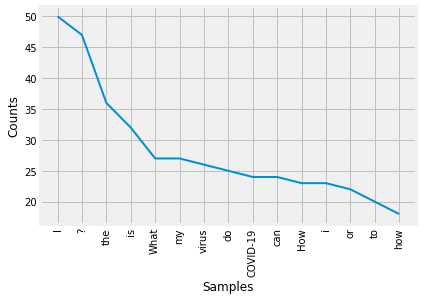

In [7]:
readFAQdb()

In [8]:
## create TFIDF Cosine Similarity model 
## TFIDF encoded data 

model = ZCosineSimilarity( ZAPP_NAME )

def resetAndTrainModel( n_gramz=(1,1) , log=True):
    if log:
        printHeadline('resetAndTrain', f"Updating Model @ ngramz={n_gramz}" ) 
    dset.encodeTrain(enc_type=zdataset.ZENC_TFIDF, ngramz=n_gramz )     
    model.build( dset.context , dset.encoded_matrix, dset.ylabelzAsInts(), dset.preprocessor)
#     print("TFIDF: {}".format( dset.context))
    

In [9]:
## Training Helpers
val_txt = ['Is corana deadly', 
           'What is corona', 
           "Should my pet get tested", 
           "Will mosquito bite infect me", 
          "Can I visit my elderly parents", 
          "Is there a vaccine"]

val_ylabz = ['covid19_define',
             'covid19_define',
            'pets_infection', 
            'covid19_spread_insects',
            'covid19_at_risk',
            'covid19_cure']

val_ylabz_int = dset.ylabelzAsInts(val_ylabz) 


def validateCosineModel(i=1, log=True):
    if log:
        print("\n{0} {1}. PREPROCESSING @ Validation Data {0}".format("-"*6, i))
    cleaned_txt = dset.preprocessPredict( val_txt)
    
    if log:
        for itx, otx in zip(val_txt, cleaned_txt):
            print("CLEANED: {} ===> {}".format(itx, otx))
        
    
    if log:
        print("\n{0} {1}. PREDICT @ Validation Data {0}".format("-"*6, i+1 ))
    acc, predicted_yz = model.validate( cleaned_txt, val_ylabz_int)
    
    for idx, txt, y in  zip( predicted_yz, val_txt, val_ylabz):
        cat,resp =  dset.getPredictedAtIndex( idx )
        if log:
            print("PREDICTED: {}:{} ===> {} for '{}' ".format(idx, y, cat, txt))
    #     print("\t{}\n".format(resp) )
    
    if log:
        print(">>> Predicted Accuracy: {} \n{}".format( acc, predicted_yz) ) 
    return acc
    

## 2. Train model using cleaned data

In [10]:
## Clean the data
updated_stopz = dset.getStopWords( ['virus', 'covid19', ]) ##Keeping covid and corona for @define
# print("STOPZ: ", ", ".join(updated_stopz) ) 



------ 3. CLEANING : WITH STOPZ ------

------ 4. FAQ : Cleaned Dataset ------
# Classes: 53
# Size training set: 153
Vocab Size: 253
Lexical Richness: 0.5039840637450199
Threshold for N-gram Vs Seq: 46.35445544554456 <<< do Seq iff > 1500
-------
Example: Source phrase: what is a pandemic?
Example: Training phrase: pandemic
Example: Associated class: pandemic_define

Example: Source phrase: how is covid-19 treated
Example: Training phrase: treated
Example: Associated class: covid19_cure
-------
FreqDist of 502 tokens.


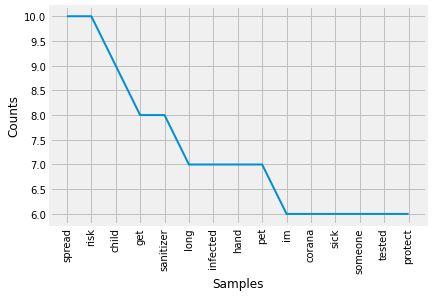

In [11]:
printHeadline('cleaning', 'WITH STOPZ')
clean_paramz = {
        'remove_stopwordz' : True,
        'stop_wordz' : updated_stopz, 
        'remove_numberz' : True, 
        'lemmatized' : True, 
    }


dset.preprocess( **clean_paramz )     

printFAQ(dset, is_cleaned=True)

In [12]:
resetAndTrainModel()
base_acc = validateCosineModel(log=False)

INFOR   : 2020-04-20 18:07:46.317331 [cosine.predict] IN.CLEAN: 2 ['corana', 'deadly']
INFOR   : 2020-04-20 18:07:46.319329 [cosine.predict] ANS: 115
INFOR   : 2020-04-20 18:07:46.320353 [cosine.predict] IN.CLEAN: 1 ['corona']
INFOR   : 2020-04-20 18:07:46.321346 [cosine.predict] ANS: 7
INFOR   : 2020-04-20 18:07:46.321346 [cosine.predict] IN.CLEAN: 3 ['pet', 'get', 'tested']
INFOR   : 2020-04-20 18:07:46.323340 [cosine.predict] ANS: 68
INFOR   : 2020-04-20 18:07:46.323340 [cosine.predict] IN.CLEAN: 3 ['mosquito', 'bite', 'infect']
INFOR   : 2020-04-20 18:07:46.324313 [cosine.predict] ANS: 80
INFOR   : 2020-04-20 18:07:46.325311 [cosine.predict] IN.CLEAN: 3 ['visit', 'elderly', 'parent']
INFOR   : 2020-04-20 18:07:46.326308 [cosine.predict] ANS: 54
INFOR   : 2020-04-20 18:07:46.327304 [cosine.predict] IN.CLEAN: 1 ['vaccine']
INFOR   : 2020-04-20 18:07:46.328302 [cosine.predict] ANS: 37



------ 5. RESETANDTRAIN : Updating Model @ ngramz=(1, 1) ------



------ 6. CLEANING : WITHOUT STOPZ ------

------ 7. FAQ : Cleaned Dataset ------
# Classes: 53
# Size training set: 153
Vocab Size: 253
Lexical Richness: 0.5039840637450199
Threshold for N-gram Vs Seq: 46.35445544554456 <<< do Seq iff > 1500
-------
Example: Source phrase: what is a pandemic?
Example: Training phrase: pandemic
Example: Associated class: pandemic_define

Example: Source phrase: can i make my cat, dog or pet sick
Example: Training phrase: make cat dog pet sick
Example: Associated class: pets_infection
-------
FreqDist of 502 tokens.


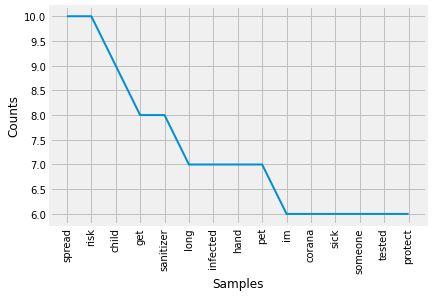

In [13]:
printHeadline('cleaning', 'WITHOUT STOPZ')

printFAQ(dset, is_cleaned=True)

In [14]:
resetAndTrainModel()
base_acc = validateCosineModel(log=False)

INFOR   : 2020-04-20 18:07:46.500840 [cosine.predict] IN.CLEAN: 2 ['corana', 'deadly']
INFOR   : 2020-04-20 18:07:46.501837 [cosine.predict] ANS: 115
INFOR   : 2020-04-20 18:07:46.502835 [cosine.predict] IN.CLEAN: 1 ['corona']
INFOR   : 2020-04-20 18:07:46.503833 [cosine.predict] ANS: 7
INFOR   : 2020-04-20 18:07:46.504830 [cosine.predict] IN.CLEAN: 3 ['pet', 'get', 'tested']
INFOR   : 2020-04-20 18:07:46.506824 [cosine.predict] ANS: 68
INFOR   : 2020-04-20 18:07:46.507821 [cosine.predict] IN.CLEAN: 3 ['mosquito', 'bite', 'infect']
INFOR   : 2020-04-20 18:07:46.508819 [cosine.predict] ANS: 80
INFOR   : 2020-04-20 18:07:46.508819 [cosine.predict] IN.CLEAN: 3 ['visit', 'elderly', 'parent']
INFOR   : 2020-04-20 18:07:46.510813 [cosine.predict] ANS: 54
INFOR   : 2020-04-20 18:07:46.510813 [cosine.predict] IN.CLEAN: 1 ['vaccine']
INFOR   : 2020-04-20 18:07:46.512808 [cosine.predict] ANS: 37



------ 8. RESETANDTRAIN : Updating Model @ ngramz=(1, 1) ------


## 3. Refine Model @ N-gram range

In [15]:

ZMODEL_ACC = {} 

ngramz = [ (1, 1), (1,2), (1,3), (2,2), (2,3), (3,3)]

clean_paramz_without_stopz = {
        'remove_stopwordz' : False,
        'remove_numberz' : True, 
        'lemmatized' : True, 
    }
clean_paramz_asis = {
        'remove_stopwordz' : False,
        'remove_numberz' : False, 
        'lemmatized' : False, 
    }

config = {
    'lemma-stopz' : clean_paramz,
    'lemma-nostopz' : clean_paramz_without_stopz, 
    'stopz-only' : {**clean_paramz, **{'lemmatized':False } } , 
    'as-is' : clean_paramz_asis 
} 

In [16]:
## try different 
for k, conf in config.items():
    dset.preprocess( **conf )
    for ng in ngramz:
        resetAndTrainModel(n_gramz=ng, log=False)
        acc = validateCosineModel(log=False)
        ZMODEL_ACC[ f'{k}_{ng}gram'] = acc

INFOR   : 2020-04-20 18:07:46.572677 [cosine.predict] IN.CLEAN: 2 ['corana', 'deadly']
INFOR   : 2020-04-20 18:07:46.573646 [cosine.predict] ANS: 115
INFOR   : 2020-04-20 18:07:46.574668 [cosine.predict] IN.CLEAN: 1 ['corona']
INFOR   : 2020-04-20 18:07:46.575640 [cosine.predict] ANS: 7
INFOR   : 2020-04-20 18:07:46.576638 [cosine.predict] IN.CLEAN: 3 ['pet', 'get', 'tested']
INFOR   : 2020-04-20 18:07:46.577635 [cosine.predict] ANS: 68
INFOR   : 2020-04-20 18:07:46.578632 [cosine.predict] IN.CLEAN: 3 ['mosquito', 'bite', 'infect']
INFOR   : 2020-04-20 18:07:46.579630 [cosine.predict] ANS: 80
INFOR   : 2020-04-20 18:07:46.580627 [cosine.predict] IN.CLEAN: 3 ['visit', 'elderly', 'parent']
INFOR   : 2020-04-20 18:07:46.581625 [cosine.predict] ANS: 54
INFOR   : 2020-04-20 18:07:46.581625 [cosine.predict] IN.CLEAN: 1 ['vaccine']
INFOR   : 2020-04-20 18:07:46.583619 [cosine.predict] ANS: 37
INFOR   : 2020-04-20 18:07:46.588636 [cosine.predict] IN.CLEAN: 2 ['corana', 'deadly']
INFOR   : 2020

INFOR   : 2020-04-20 18:07:46.728233 [cosine.predict] IN.CLEAN: 3 ['is', 'corana', 'deadly']
INFOR   : 2020-04-20 18:07:46.730227 [cosine.predict] ANS: 8
INFOR   : 2020-04-20 18:07:46.730227 [cosine.predict] IN.CLEAN: 3 ['what', 'is', 'corona']
INFOR   : 2020-04-20 18:07:46.732221 [cosine.predict] ANS: 8
INFOR   : 2020-04-20 18:07:46.732221 [cosine.predict] IN.CLEAN: 5 ['should', 'my', 'pet', 'get', 'tested']
INFOR   : 2020-04-20 18:07:46.733219 [cosine.predict] ANS: 86
INFOR   : 2020-04-20 18:07:46.734216 [cosine.predict] IN.CLEAN: 5 ['will', 'mosquito', 'bite', 'infect', 'me']
INFOR   : 2020-04-20 18:07:46.735214 [cosine.predict] ANS: 23
INFOR   : 2020-04-20 18:07:46.736211 [cosine.predict] IN.CLEAN: 6 ['can', 'i', 'visit', 'my', 'elderly', 'parent']
INFOR   : 2020-04-20 18:07:46.738206 [cosine.predict] ANS: 118
INFOR   : 2020-04-20 18:07:46.738206 [cosine.predict] IN.CLEAN: 4 ['is', 'there', 'a', 'vaccine']
INFOR   : 2020-04-20 18:07:46.741197 [cosine.predict] ANS: 8
INFOR   : 2020-

INFOR   : 2020-04-20 18:07:46.891795 [cosine.predict] ANS: 152
INFOR   : 2020-04-20 18:07:46.892792 [cosine.predict] IN.CLEAN: 1 ['vaccine']
INFOR   : 2020-04-20 18:07:46.894787 [cosine.predict] ANS: 152
INFOR   : 2020-04-20 18:07:46.900771 [cosine.predict] IN.CLEAN: 2 ['corana', 'deadly']
INFOR   : 2020-04-20 18:07:46.901768 [cosine.predict] ANS: 152
INFOR   : 2020-04-20 18:07:46.902766 [cosine.predict] IN.CLEAN: 1 ['corona']
INFOR   : 2020-04-20 18:07:46.903764 [cosine.predict] ANS: 152
INFOR   : 2020-04-20 18:07:46.904760 [cosine.predict] IN.CLEAN: 3 ['pet', 'get', 'tested']
INFOR   : 2020-04-20 18:07:46.905757 [cosine.predict] ANS: 152
INFOR   : 2020-04-20 18:07:46.906755 [cosine.predict] IN.CLEAN: 3 ['mosquito', 'bite', 'infect']
INFOR   : 2020-04-20 18:07:46.907751 [cosine.predict] ANS: 152
INFOR   : 2020-04-20 18:07:46.907751 [cosine.predict] IN.CLEAN: 3 ['visit', 'elderly', 'parents']
INFOR   : 2020-04-20 18:07:46.909746 [cosine.predict] ANS: 152
INFOR   : 2020-04-20 18:07:46.9

INFOR   : 2020-04-20 18:07:47.024440 [cosine.predict] ANS: 152
INFOR   : 2020-04-20 18:07:47.024440 [cosine.predict] IN.CLEAN: 5 ['will', 'mosquito', 'bite', 'infect', 'me']
INFOR   : 2020-04-20 18:07:47.025437 [cosine.predict] ANS: 152
INFOR   : 2020-04-20 18:07:47.026435 [cosine.predict] IN.CLEAN: 6 ['can', 'i', 'visit', 'my', 'elderly', 'parents']
INFOR   : 2020-04-20 18:07:47.027432 [cosine.predict] ANS: 152
INFOR   : 2020-04-20 18:07:47.027432 [cosine.predict] IN.CLEAN: 4 ['is', 'there', 'a', 'vaccine']
INFOR   : 2020-04-20 18:07:47.029426 [cosine.predict] ANS: 152


findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=14.399999999999999.
findfont: score(<Font 'STIXNonUnicode' (STIXNonUniBolIta.ttf) italic normal bold normal>) = 11.335
findfont: score(<Font 'STIXGeneral' (STIXGeneralItalic.ttf) italic normal 400 normal>) = 11.05
findfont: score(<Font 'STIXSizeFourSym' (STIXSizFourSymReg.ttf) normal normal regular normal>) = 10.05
findfont: score(<Font 'STIXGeneral' (STIXGeneralBol.ttf) normal normal bold normal>) = 10.335
findfont: score(<Font 'DejaVu Sans Mono' (DejaVuSansMono-Oblique.ttf) oblique normal 400 normal>) = 11.05
findfont: score(<Font 'STIXNonUnicode' (STIXNonUni.ttf) normal normal regular normal>) = 10.05
findfont: score(<Font 'cmex10' (cmex10.ttf) normal normal 400 normal>) = 10.05
findfont: score(<Font 'DejaVu Sans Mono' (DejaVuSansMono-BoldOblique.ttf) oblique normal bold normal>) = 11.335
findfont: score(<Font 'DejaVu Sans Display' (DejaVuSansDisplay.ttf) normal normal 400 normal>) = 10.05
f

findfont: score(<Font 'Bodoni MT' (BOD_CB.TTF) normal normal bold condensed>) = 10.535
findfont: score(<Font 'Corbel' (corbelb.ttf) normal normal bold normal>) = 10.335
findfont: score(<Font 'Lucida Sans Typewriter' (LTYPEB.TTF) normal normal bold normal>) = 10.335
findfont: score(<Font 'MS Outlook' (OUTLOOK.TTF) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Century Gothic' (GOTHIC.TTF) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Webdings' (webdings.ttf) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Blackadder ITC' (ITCBLKAD.TTF) normal normal black normal>) = 10.525
findfont: score(<Font 'Perpetua' (PER_____.TTF) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Segoe Print' (segoeprb.ttf) normal normal bold normal>) = 10.335
findfont: score(<Font 'Corbel' (corbeli.ttf) italic normal 400 normal>) = 11.05
findfont: score(<Font 'Calibri' (calibri.ttf) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Courier New' (courbi.ttf) italic 

findfont: score(<Font 'Bodoni MT' (BOD_CI.TTF) italic normal 400 condensed>) = 11.25
findfont: score(<Font 'Calisto MT' (CALIST.TTF) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Bradley Hand ITC' (BRADHITC.TTF) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Californian FB' (CALIFI.TTF) italic normal 400 normal>) = 11.05
findfont: score(<Font 'Stencil' (STENCIL.TTF) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Calisto MT' (CALISTI.TTF) italic normal 400 normal>) = 11.05
findfont: score(<Font 'Century Gothic' (GOTHICI.TTF) italic normal 400 normal>) = 11.05
findfont: score(<Font 'Monotype Corsiva' (MTCORSVA.TTF) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Goudy Old Style' (GOUDOS.TTF) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Candara' (Candara.ttf) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Century Schoolbook' (SCHLBKI.TTF) italic normal book normal>) = 11.05
findfont: score(<Font 'Bodoni MT' (BOD_R.TTF) no

findfont: score(<Font 'Segoe UI' (segoeuib.ttf) normal normal bold normal>) = 10.335
findfont: score(<Font 'Calibri' (calibriz.ttf) italic normal bold normal>) = 11.335
findfont: score(<Font 'Gill Sans Ultra Bold Condensed' (GILLUBCD.TTF) normal normal bold condensed>) = 10.535
findfont: score(<Font 'MT Extra' (MTEXTRA.TTF) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Courier New' (couri.ttf) italic normal 400 normal>) = 11.05
findfont: score(<Font 'Garamond' (GARAIT.TTF) italic normal 400 normal>) = 11.05
findfont: score(<Font 'Century Gothic' (GOTHICB.TTF) normal normal bold normal>) = 10.335
findfont: score(<Font 'Segoe MDL2 Assets' (segmdl2.ttf) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Chiller' (CHILLER.TTF) normal normal 400 normal>) = 10.05
findfont: score(<Font 'High Tower Text' (HTOWERT.TTF) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Bodoni MT' (BOD_CBI.TTF) italic normal bold condensed>) = 11.535
findfont: score(<Font 'Calisto MT' (

findfont: score(<Font 'Trebuchet MS' (trebuc.ttf) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Verdana' (verdanab.ttf) normal normal bold normal>) = 3.9713636363636367
findfont: score(<Font 'Bodoni MT' (BOD_I.TTF) italic normal 400 normal>) = 11.05
findfont: score(<Font 'Tw Cen MT Condensed Extra Bold' (TCCEB.TTF) normal normal bold condensed>) = 10.535
findfont: score(<Font 'Microsoft PhagsPa' (phagspa.ttf) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Tw Cen MT Condensed' (TCCM____.TTF) normal normal 400 condensed>) = 10.25
findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=14.399999999999999 to DejaVu Sans ('C:\\Users\\bilha\\Anaconda3\\lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\DejaVuSans.ttf') with score of 0.050000.


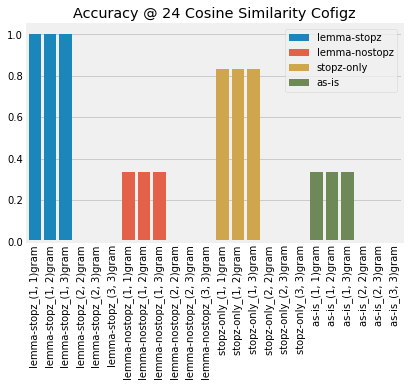

In [17]:
## Plot them 
def plotAcc(x_srcz, y_valz, huez, ttitle='Cosine Similarity'):
    g = sns.barplot( x=x_srcz, y=y_valz, hue=huez, dodge=False)
    g.set_title("Accuracy @ {} {} Cofigz".format(len(x_srcz), ttitle))
    g.set_xticklabels(g.get_xticklabels(), rotation=90, horizontalalignment='center')
    plt.legend(loc='upper right')
    plt.show()

plotAcc( list(ZMODEL_ACC.keys()), list(ZMODEL_ACC.values()), [ x.split('_')[0] for x in ZMODEL_ACC.keys() ] )

## 4. Save Model for Reuse

In [18]:
## 1. Run with choice COnfig
choice_conf = {
        'remove_stopwordz' : True,
        'stop_wordz' : updated_stopz, 
        'remove_numberz' : True, 
        'lemmatized' : True, 
    }

dset.preprocess( **choice_conf )
resetAndTrainModel(n_gramz=(1,1), log=False)
validateCosineModel(log=False)
print(model)

INFOR   : 2020-04-20 18:07:47.598903 [cosine.predict] IN.CLEAN: 2 ['corana', 'deadly']
INFOR   : 2020-04-20 18:07:47.599900 [cosine.predict] ANS: 115
INFOR   : 2020-04-20 18:07:47.600897 [cosine.predict] IN.CLEAN: 1 ['corona']
INFOR   : 2020-04-20 18:07:47.601895 [cosine.predict] ANS: 7
INFOR   : 2020-04-20 18:07:47.602892 [cosine.predict] IN.CLEAN: 3 ['pet', 'get', 'tested']
INFOR   : 2020-04-20 18:07:47.603918 [cosine.predict] ANS: 68
INFOR   : 2020-04-20 18:07:47.604917 [cosine.predict] IN.CLEAN: 3 ['mosquito', 'bite', 'infect']
INFOR   : 2020-04-20 18:07:47.605913 [cosine.predict] ANS: 80
INFOR   : 2020-04-20 18:07:47.605913 [cosine.predict] IN.CLEAN: 3 ['visit', 'elderly', 'parent']
INFOR   : 2020-04-20 18:07:47.607880 [cosine.predict] ANS: 54
INFOR   : 2020-04-20 18:07:47.607880 [cosine.predict] IN.CLEAN: 1 ['vaccine']
INFOR   : 2020-04-20 18:07:47.608877 [cosine.predict] ANS: 37


1.0

<class 'zmodel_cosine_similarity.ZCosineSimilarity'> ncov19_tfidf_faq with model file 'ncov19_tfidf_faq.zmd'


In [19]:
## 2. Save to file
model.dumpSave( ) 

INFOR   : 2020-04-20 18:07:47.614860 [<class 'zmodel_cosine_similarity.ZCosineSimilarity'>.model.dump] Model saved to file successfully - ncov19_tfidf_faq.zmd
